## A 250-hPa Hemispheric Ageostrophic Geopotential Flux
By: Kevin Goebbert

Date: 24 June 2015

Modified: 27 October 2016, 5 April 2017, 18 February 2019



In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib
matplotlib.use('TkAgg') # do this before importing pylab
import matplotlib.pyplot as plt
#from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
#import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
import cartopy.util as cutil
import netCDF4
import scipy.ndimage as ndimage
from datetime import datetime, timedelta
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS
from metpy.units import units
import metpy.calc as mpcalc
import metpy.constants

The next cell is going to pull in the GFS dataset from the Thredds server

In [3]:
# Latest GFS Dataset
cat = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p5deg_ana/catalog.xml')
best_ds = list(cat.datasets.values())[0]
ncss = NCSS(best_ds.access_urls['NetcdfSubset'])
now = datetime.utcnow()
# Query for Best GFS Dataset 7 days before current to current
gfsdata = ncss.query().time_range(datetime(2019,1,30,0),datetime(2019,1,30,6))

# Query for Latest GFS Run
#gfsdata = ncss.query().all_times()
gfsdata.accept('netcdf4').variables('Geopotential_height_isobaric',
                                    'u-component_of_wind_isobaric',
                                    'v-component_of_wind_isobaric').add_lonlat()
# Set the lat/lon box for the data you want to pull in.
# lonlat_box(north_lat,south_lat,east_lon,west_lon)
gfsdata.lonlat_box(0,360,0,90)
# Set desired level 50000 = 50000 Pa = 500 hPa
gfsdata.vertical_level(25000)
# Actually getting the data
data = ncss.get_data(gfsdata)

The next cell will take the downloaded data and parse it to different variables for use later on.

Smooth the 250-hPa heights using a gaussian filter from scipy.ndimage

Converting times using the num2date function available through netCDF4

In [4]:
dtime = data.variables['Geopotential_height_isobaric'].dimensions[0]
dlat  = data.variables['Geopotential_height_isobaric'].dimensions[2]
dlon  = data.variables['Geopotential_height_isobaric'].dimensions[3]
lat = data.variables[dlat][:]
lon = cutil.add_cyclic_point(data.variables[dlon][:])
times = data.variables[dtime]
vtimes = netCDF4.num2date(times[:],times.units)
ntimes = vtimes.size
#print(lon.shape)
hgt_250 = cutil.add_cyclic_point(data.variables['Geopotential_height_isobaric'][:].squeeze())

cint = 120
clev250 = np.arange(9000,12000,cint)
#clev500 = np.arange(3800,6200,60)


clevsped250 = np.arange(50,230,20)
print(hgt_250.shape)

#mean_hght_lat = np.repeat(np.average(Z_250,axis=2)[:,:,np.newaxis],721,axis=2)
#anom_hght_lat = Z_250 - mean_hght_lat

(2, 181, 721)


In [5]:
print(vtimes[0])

2019-01-30 00:00:00


The next cell sets up the geographic details for the plot that we are going to do later. This is done using the Cartopy package. We will also bring in some geographic data to geo-reference the image for us.

In [6]:
#crs = ccrs.LambertConformal(central_longitude=-100.0, central_latitude=45.0)
crs = ccrs.NorthPolarStereo(central_longitude=-100.0)
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lakes',
        scale='50m',
        facecolor='none')

The next cell transforms our lat/lon projection from PlateCarree to Lambert Conformal

In [7]:
# Make a grid of lat/lon values to use for plotting with Cartopy.
lons, lats = np.meshgrid(lon, lat)

tlatlons = crs.transform_points(ccrs.PlateCarree(),lons,lats)
clons = tlatlons[:,:,0]
clats = tlatlons[:,:,1]

In [8]:
gravity = metpy.constants.g
f = mpcalc.coriolis_parameter(np.deg2rad(lats)).to(units('1 / sec'))

dx, dy = mpcalc.lat_lon_grid_spacing(lon,lat)

(181, 720)


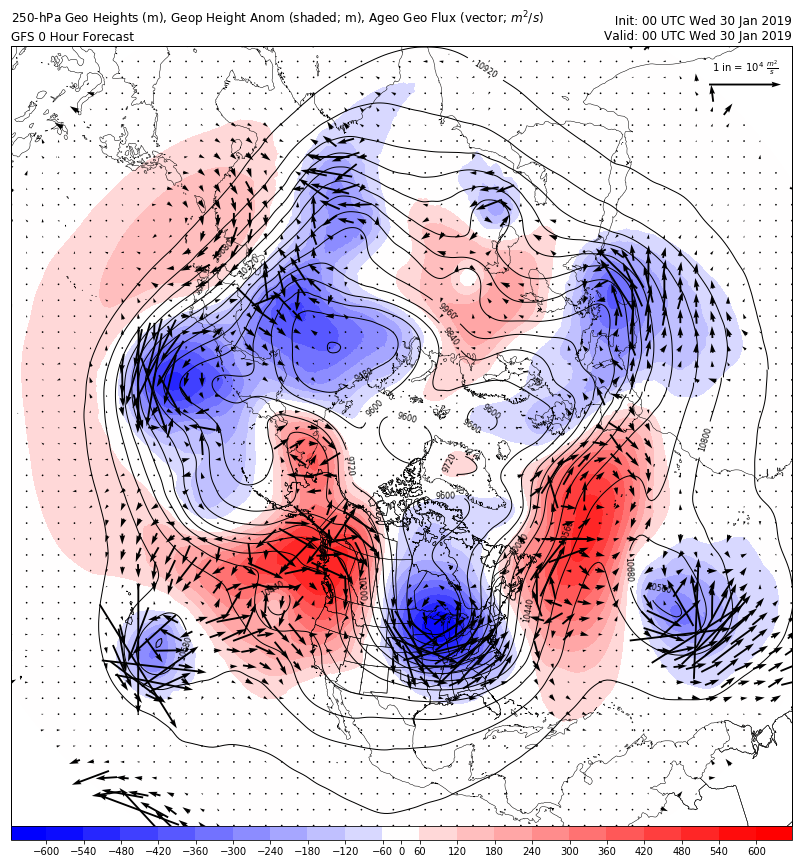

In [10]:
#HOUR = 0
%matplotlib inline

#for HOUR in range(ntimes):
for HOUR in range(1):
    #mean_hght_lat = np.repeat(np.average(hgt_250[HOUR],axis=1)[:,np.newaxis],721,axis=1)
    mean_hght_lat = np.average(hgt_250[HOUR], axis=1)[:,None]
    anom_hght_lat = hgt_250[HOUR] - mean_hght_lat
    
    Z_250 = ndimage.gaussian_filter(hgt_250[HOUR], sigma=1.5, order=0)
    ug250, vg250 = mpcalc.geostrophic_wind(Z_250 * units.meter, f, dx, -dy, dim_order='yx')
    
    u250 = cutil.add_cyclic_point(data.variables['u-component_of_wind_isobaric'][HOUR].squeeze()) * units('m/s')
    v250 = cutil.add_cyclic_point(data.variables['v-component_of_wind_isobaric'][HOUR].squeeze()) * units('m/s')
    wspd250 = mpcalc.get_wind_speed(u250,v250)
    
    fig=plt.figure(1,figsize=(14.,17.))
    ax = plt.subplot(111,projection=crs)
    #   ax.set_extent([west long, east long, south lat, north lat])
    

    ax.set_extent([-180, 180, 10, 90], ccrs.PlateCarree())
    ax.coastlines('50m',edgecolor='black',linewidth=0.5)
    ax.add_feature(states_provinces,edgecolor='black',linewidth=0.5)
    cs = ax.contour(clons,clats,Z_250[:,:],clev250,colors='k',linewidths=1.0,linestyles='solid')

    cint = np.arange(-600,601,60)
    cf = ax.contourf(clons,clats,anom_hght_lat[:,:],cint[(cint != 0)],cmap=plt.cm.bwr,extend='both')
    plt.clabel(cs, fontsize=8, inline=1, inline_spacing=10, fmt='%i', rightside_up=True, use_clabeltext=True)

    # Transform Vectors before plotting, then plot wind barbs.
    #ut, vt = crs.transform_vectors(ccrs.PlateCarree(),lons,lats,
    #                               (u250[HOUR,:,:].magnitude-ug.magnitude)*anom_hght_lat[HOUR,:,:],
    #                               (v250[HOUR,:,:].magnitude-vg.magnitude)*anom_hght_lat[HOUR,:,:])
    u250t, v250t = crs.transform_vectors(ccrs.PlateCarree(),lons,lats,
                                         u250[:,:],
                                         v250[:,:])
    ug250t, vg250t = crs.transform_vectors(ccrs.PlateCarree(),lons,lats,
                                           ug250[:,:].magnitude,
                                           vg250[:,:].magnitude)

    ugeo250flux = (u250t-ug250t)*anom_hght_lat[:,:]
    vgeo250flux = (v250t-vg250t)*anom_hght_lat[:,:]
    #print(np.nanmax(ugeo250flux[np.isfinite(ugeo250flux)]))

    q = ax.quiver(clons, clats, ugeo250flux, vgeo250flux, pivot='mid', angles='uv', 
                  regrid_shape=50, scale=10000, scale_units='inches')
    #q = ax.quiver(clons[:-1,:], clats[:-1,:], ug250t[:-1,:], vg250t[:-1,:], pivot='mid', angles='uv', 
    #              regrid_shape=50, scale_units='inches')
    ax.quiverkey(q,.94,.95,10000, r'1 in = $10^4$ $\frac{m^2}{s}$')
    

    #bbox = ax.get_position()
    #cax = fig.add_axes([bbox.xmin, bbox.ymin+0.02, bbox.width, bbox.height*0.02])
    cmap = plt.cm.get_cmap("BuPu")
    plt.colorbar(cf,orientation='horizontal',extend='max',extendrect='True',ticks=cint,pad=0,aspect=50)
    
    ax.set_title(r'250-hPa Geo Heights (m), Geop Height Anom (shaded; m), '
                 'Ageo Geo Flux (vector; $m^2/s$)\n'
                 'GFS {} Hour Forecast'.format(0),loc='left')
    ax.set_title(' Init: {:%H UTC %a %d %b %Y}\n'
                 'Valid: {:%H UTC %a %d %b %Y}'.format(vtimes[0],vtimes[HOUR]), loc='right')
    #ax.set_title('\nVALID: %s' %(vtimes[HOUR]),loc='right')
    plt.tight_layout()
    
    #plt.savefig('ageoflux_'+str(HOUR)+'.png')
    plt.show()
    plt.close()